# How to use pyransac, detailed example

In [1]:
#First, some visualization functions
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pyransac
from time import time
from copy import deepcopy

#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentatives, img1, img2, H, mask):
    if H is None:
        print ("No homography found")
        return
    matchesMask = mask.ravel().tolist()
    h,w,ch = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, H)
    #print (dst)
    #Ground truth transformation
    dst_GT = cv2.perspectiveTransform(pts, H_gt)
    img2_tr = cv2.polylines(decolorize(img2),[np.int32(dst)],True,(0,0,255),3, cv2.LINE_AA)
    img2_tr = cv2.polylines(deepcopy(img2_tr),[np.int32(dst_GT)],True,(0,255,0),3, cv2.LINE_AA)
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2_tr,kps2,tentatives,None,**draw_params)
    plt.figure()
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img_out, interpolation='nearest')
    return

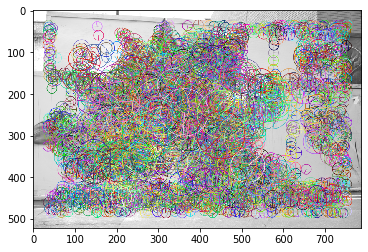

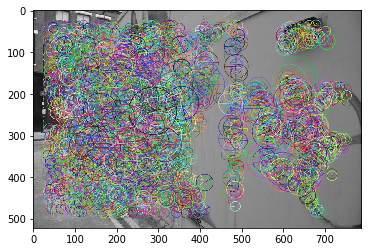

In [2]:
#Lets load some images and detect some featues
# Images are from HSequences dataset  https://github.com/hpatches/hpatches-dataset
img1 = cv2.cvtColor(cv2.imread('img/v_dogman/1.ppm'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('img/v_dogman/6.ppm'), cv2.COLOR_BGR2RGB)


H_gt =np.loadtxt('img/v_dogman/H_1_6')

# SIFT is not available by pip install, so lets use AKAZE features
det = cv2.AKAZE_create(descriptor_type = 3, threshold=0.00002)
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)


# AKAZE features output "detection" scale, which is 6x less than one used for descriptor
# For correct drawing, we increase it manually
for i in range(len(kps1)):
    kps1[i].size = 5*kps1[i].size
for i in range(len(kps2)):
    kps2[i].size = 5*kps2[i].size

vis_img1, vis_img2 = None,None
vis_img1 = cv2.drawKeypoints(cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY),kps1,vis_img1, 
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
vis_img2 = cv2.drawKeypoints(cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY),kps2,vis_img2, 
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(vis_img1)
plt.figure()
plt.imshow(vis_img2)

In [3]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(descs1,descs2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [False for i in range(len(matches))]

# SNN ratio test
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        matchesMask[i]=True
tentatives = [m[0] for i, m in enumerate(matches) if matchesMask[i] ]

# Input format

pyransac accepts following input formats:
 1. [nx2]  np arrays of xy coordinates -- as OpenCV RANSAC
 2. list of OpenCV keypoints 
 3. [nx6] np array of affine keypoints x y a11 a12 a21 a22

In cases 2) and 3)  it is possible to perform local affine frame consistency check (LAF-check).
The procedure uses coordinates of the closest and furthest ellipse points from the ellipse center of both matched local
affine frames to check whether the whole local feature is consistent with estimated geometry model.

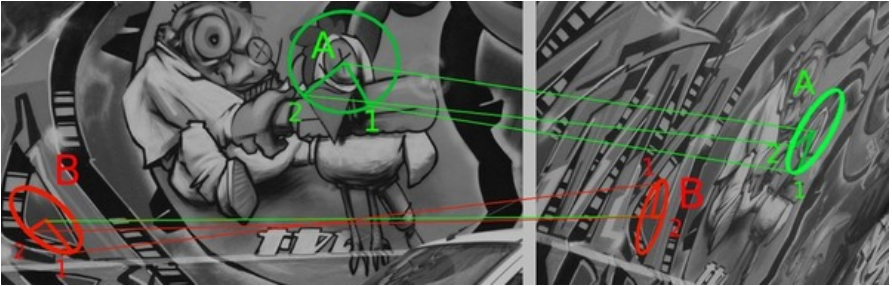
Illustration is from [MODS paper](https://arxiv.org/pdf/1503.02619.pdf)


0.00374  sec pyransac
pyransac found 56 inliers


<Figure size 432x288 with 0 Axes>

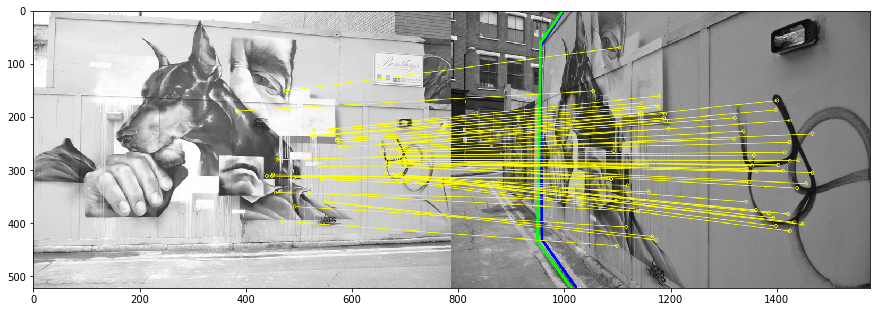

In [4]:
# input format 1
t=time()
src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)

H, mask = pyransac.findHomography(src_pts,
                                      dst_pts,
                                      4.0,
                                      0.99,
                                      2000)

print ("{0:.5f}".format(time()-t), ' sec pyransac')
print ('pyransac found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
draw_matches(kps1, kps2, tentatives, img1, img2, H, mask)

0.01254  sec pyransac
pyransac found 54 inliers


<Figure size 432x288 with 0 Axes>

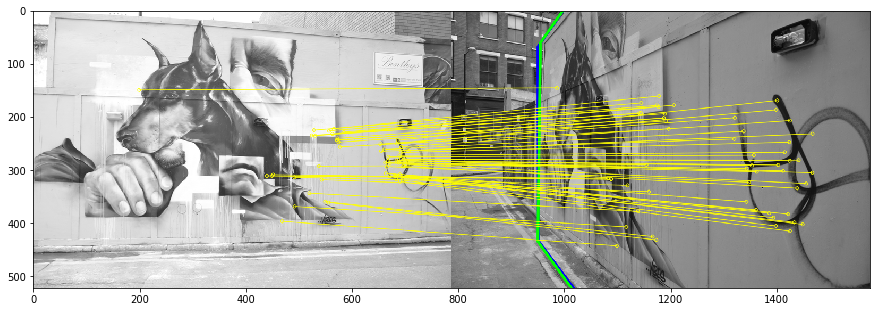

In [5]:
# input format 2
t=time()
src_pts = [kps1[m.queryIdx] for m in tentatives]
dst_pts = [kps2[m.trainIdx] for m in tentatives]

H, mask = pyransac.findHomography(src_pts,
                                      dst_pts,
                                      4.0,
                                      0.99,
                                      2000,
                                      laf_consistensy_coef=0)

print ("{0:.5f}".format(time()-t), ' sec pyransac')
print ('pyransac found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
draw_matches(kps1, kps2, tentatives, img1, img2, H, mask)

# Advanced options
As usual, you may set pixel threshold for point to could as inlier, max_iters and confidence
Besides this, there are following options:

- **laf_consistensy_coef**. If > 0, it means that scale and orientation of the feature will be checked for consistency with the far-the-best found model. The threshold for checking px_th * laf_consistensy_coef.  Becayse they are usually less precise that keypoint center, it is recommended toset laf_consistensy_coef > 1, e.g. 3. 
- **error_type**. The measure of the correspondence quality. Can be 'sampson', 'symm_sq_max', 'symm_max', 'symm_sq_sum', 'symm_sum'. For precise definition, please take a look to Chapter 4.2 Hartley and Zisserman "[Multi View Geometry](http://cvrs.whu.edu.cn/downloads/ebooks/Multiple%20View%20Geometry%20in%20Computer%20Vision%20(Second%20Edition).pdf)"
- **symmetric_error_check** If one should perform the additional check of the inliers with 'symm_max' error type. For detailed explanation, see example below

0.00890  sec pyransac
pyransac found 54 inliers


<Figure size 432x288 with 0 Axes>

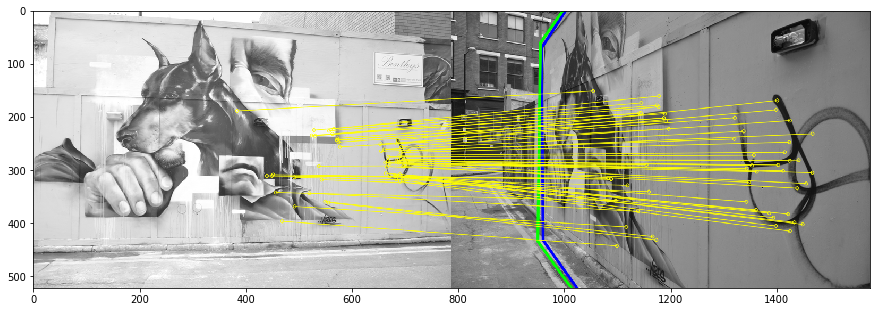

In [6]:
t=time()
H, mask = pyransac.findHomography(src_pts,
                                      dst_pts,
                                      px_th = 4.0,
                                      conf = 0.99,
                                      max_iters = 2000,
                                      laf_consistensy_coef=3.0,
                                      error_type='sampson',
                                      symmetric_error_check=True)

print ("{0:.5f}".format(time()-t), ' sec pyransac')
print ('pyransac found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
draw_matches(kps1, kps2, tentatives, img1, img2, H, mask)

# Rerpojection error types

The commonly used error to minimize in RANSAC is **symmetrical reprojection error**. 

It is good and stable, but gives inferior results when [local optimizaiton](ftp://cmp.felk.cvut.cz/pub/cmp/articles/matas/chum-dagm03.pdf) is used.

From other side, **Sampson error** is good for optimization, but prone to  some type of degenerate solutions, see an example below.

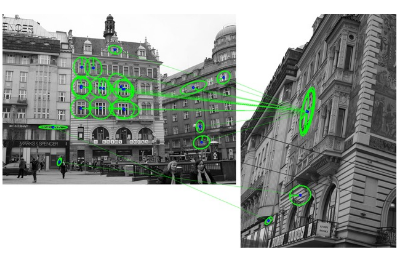



*pyransac* solves this problem the following way: Sampson error is used for optimization, but far-the-best model is also undergoes check with symmetrical reprojection error. If it is not passed, the model is rejected. This is enabled by **symmetric_error_check** flag

In [7]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(descs1,descs2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [False for i in range(len(matches))]

# For emulating bad quality of the correspondences, we will turn off the ratio check check for tentatives
# SNN ratio test
for i,(m,n) in enumerate(matches):
    if m.distance < 0.97*n.distance:
        matchesMask[i]=True
tentatives = [m[0] for i, m in enumerate(matches) if matchesMask[i] ]
src_pts = [kps1[m.queryIdx] for m in tentatives]
dst_pts = [kps2[m.trainIdx] for m in tentatives]


0.04743  sec pyransac
pyransac with Sampson error found 88 inliers


<Figure size 432x288 with 0 Axes>

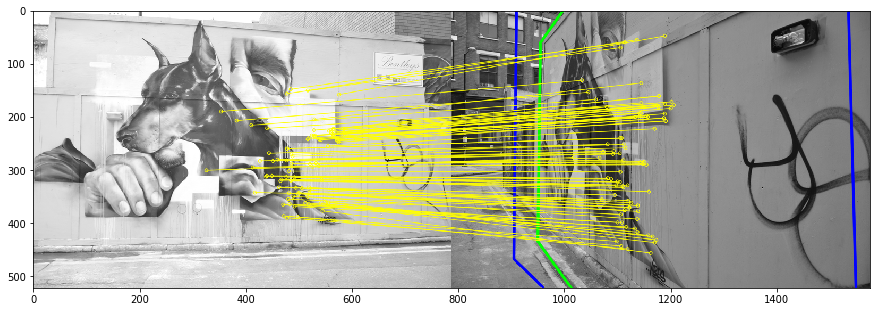

In [8]:
#Sampson error alone
t=time()
H, mask = pyransac.findHomography(src_pts,
                                      dst_pts,
                                      px_th = 4.0,
                                      conf = 0.99,
                                      max_iters = 2000,
                                      laf_consistensy_coef=0,
                                      error_type='sampson',
                                      symmetric_error_check=False)

print ("{0:.5f}".format(time()-t), ' sec pyransac')
print ('pyransac with Sampson error found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
draw_matches(kps1, kps2, tentatives, img1, img2, H, mask)

0.03137  sec pyransac
pyransac with symmetric reprojection error found 9 inliers


<Figure size 432x288 with 0 Axes>

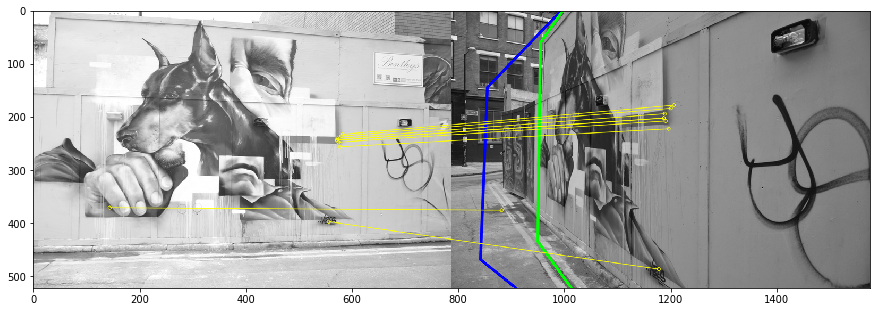

In [9]:
#symmetric reprojection error error alone
t=time()
H, mask = pyransac.findHomography(src_pts,
                                      dst_pts,
                                      px_th = 4.0,
                                      conf = 0.99,
                                      max_iters = 2000,
                                      laf_consistensy_coef=0,
                                      error_type='symm_sq_max',
                                      symmetric_error_check=False)

print ("{0:.5f}".format(time()-t), ' sec pyransac')
print ('pyransac with symmetric reprojection error found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
draw_matches(kps1, kps2, tentatives, img1, img2, H, mask)

0.05101  sec pyransac
pyransac with Sampson error + symmetric_error_check found 157 inliers


<Figure size 432x288 with 0 Axes>

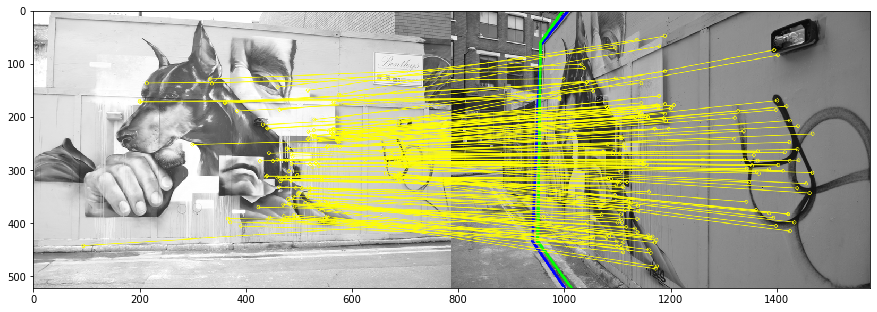

In [11]:
#Sampson error  + symmetric_error_check
t=time()
H, mask = pyransac.findHomography(src_pts,
                                      dst_pts,
                                      px_th = 4.0,
                                      conf = 0.99,
                                      max_iters = 2000,
                                      laf_consistensy_coef=0,
                                      error_type='sampson',
                                      symmetric_error_check=True)

print ("{0:.5f}".format(time()-t), ' sec pyransac')
print ('pyransac with Sampson error + symmetric_error_check found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
draw_matches(kps1, kps2, tentatives, img1, img2, H, mask)

0.04746  sec pyransac
pyransac w/o LAF check found 163 inliers
0.04639  sec pyransac
pyransac with LAF check found 166 inliers


<Figure size 432x288 with 0 Axes>

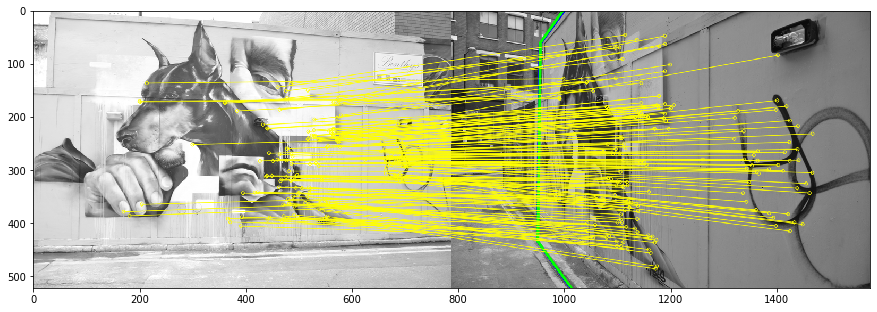

<Figure size 432x288 with 0 Axes>

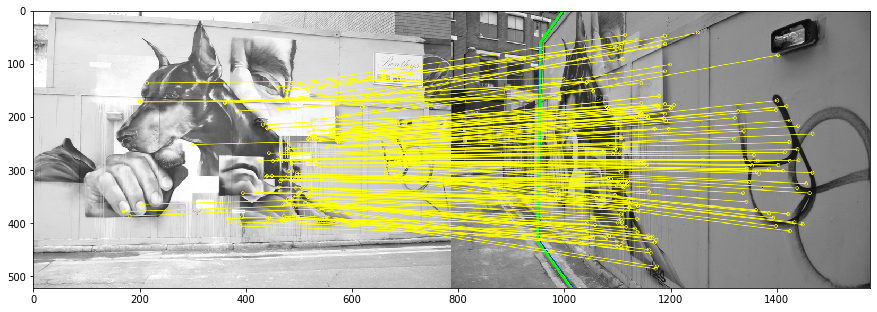

In [12]:
#LAF check (for current image pair not much useful, actually :)
t=time()
H, mask = pyransac.findHomography(src_pts,
                                      dst_pts,
                                      px_th = 4.0,
                                      conf = 0.99,
                                      max_iters = 2000,
                                      laf_consistensy_coef=0,
                                      error_type='sampson',
                                      symmetric_error_check=True)
print ("{0:.5f}".format(time()-t), ' sec pyransac')
print ('pyransac w/o LAF check found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
draw_matches(kps1, kps2, tentatives, img1, img2, H, mask)
t=time()
H_laf, mask_laf = pyransac.findHomography(src_pts,
                                      dst_pts,
                                      px_th = 4.0,
                                      conf = 0.99,
                                      max_iters = 2000,
                                      laf_consistensy_coef=3.0,
                                      error_type='sampson',
                                      symmetric_error_check=True)
print ("{0:.5f}".format(time()-t), ' sec pyransac')
print ('pyransac with LAF check found {} inliers'.format(int(deepcopy(mask_laf).astype(np.float32).sum())))
draw_matches(kps1, kps2, tentatives, img1, img2, H_laf, mask_laf)